In [5]:
from __future__ import print_function

import numpy as np
#import reflexxes
import random
import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
import datetime

import pickle

# plot data function
def on_key_press(event):
    if event.key == 'escape':
        plt.close()
        
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()
    
def plot_trajectory(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')
    plt.savefig(title + ".png")
            
def plot_mean(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.scatter(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.scatter(xline, yline, zline, 'red')
    plt.savefig(title + ".png")

def meanEuclideanDistanceError(noise, real, model):
    pred = model.predict(noise)
    error = 0
    for i in range(len(pred)):
        point = model.means_[pred[i]]
        error += ((real[i][0] - point[0]) ** 2 + (real[i][1] - point[1]) ** 2 + (real[i][2] - point[2]) ** 2) ** 0.5
    return error/len(real)

In [12]:
# Hui Min CHANGE ME~~ : number of component in each diagonal
num = 5  

# load  clean data
org_p = np.loadtxt('../Trajectory/data/outlier_0.01-c/ori_position.csv', delimiter=' ')
#org_p = np.loadtxt('../Trajectory/data0503/original_position_list.csv', delimiter=' ')
org_v = np.loadtxt('../Trajectory/data0503/original_velocity_list.csv', delimiter=' ')

traj_lens = np.loadtxt('../Trajectory/data0503/traj_lens.csv', delimiter=' ')
traj_lens = traj_lens.astype(int)

outlier_indices = np.loadtxt('../Trajectory/data/outlier_0.01-c/outlier_indices.csv', delimiter=' ')
outlier_indices = outlier_indices.astype(int)

# load noisy data
nos_p_01 = np.loadtxt('../Trajectory/data0503/position_noise_0.1.csv', delimiter=' ')
nos_p_1 = np.loadtxt('../Trajectory/data0503/position_noise_1.csv', delimiter=' ')
nos_p_2 = np.loadtxt('../Trajectory/data0503/position_noise_2.csv', delimiter=' ')
#nos_p_5 = np.loadtxt('../Trajectory/data0503/position_noise_5.csv', delimiter=' ')
nos_p_5 = np.loadtxt('../Trajectory/data/outlier_0.01-c/with_outlier_position.csv', delimiter=' ')


# reframe dataset as per traj_lens
traj_lens_cumsum = traj_lens.cumsum()
traj_lens_cumsum = np.delete(traj_lens_cumsum, len(traj_lens_cumsum) - 1)

org_p_spl = np.split(org_p, traj_lens_cumsum, axis=0)
org_v_spl = np.split(org_v, traj_lens_cumsum, axis=0)
nos_p_01_spl = np.split(nos_p_01, traj_lens_cumsum, axis=0)
nos_p_1_spl = np.split(nos_p_1, traj_lens_cumsum, axis=0)
nos_p_2_spl = np.split(nos_p_2, traj_lens_cumsum, axis=0)
nos_p_5_spl = np.split(nos_p_5, traj_lens_cumsum, axis=0)

#print(f'org_p.size: {len(org_p_spl)}')
#print(f'nos_p_01_spl.size: {len(nos_p_01_spl)}')
#print(f'nos_p_1_spl.size: {len(nos_p_1_spl)}')
#print(f'nos_p_2_spl.size: {len(nos_p_2_spl)}')
#print(f'nos_p_5_spl.size: {len(nos_p_5_spl)}')

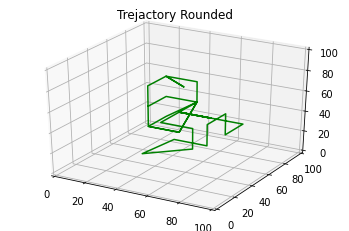

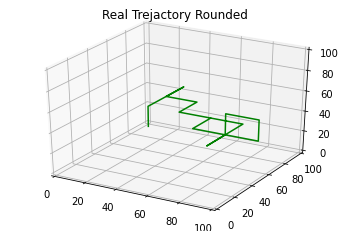

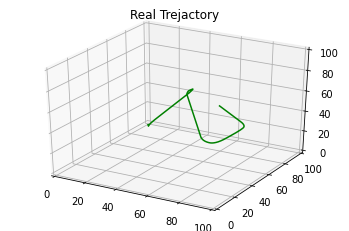

In [13]:
#with open("May03_5x5x5_noise5.pkl", "rb") as file: HMM_10 = pickle.load(file)
with open("May03_5x5x5.pkl", "rb") as file: HMM_10 = pickle.load(file)

## plot means
#plot_mean(HMM_10.means_, 'Mean Positions of 125 Components')
#plt.savefig("Mean Positions of 125 Components.png")

#select_traj = 10

# load noise data for predict
replace = nos_p_5[0:2000]
#replace = nos_p_5_spl[select_traj] 
#replace = org_p_spl[select_traj] 

# load clean data for comparison
real= org_p[0:2000]    
#real= org_p_spl[select_traj] 

pred = HMM_10.predict(replace)
orig_rd = np.ceil(real/20)*20-10
trej_rd = []
trej = []

for point in pred:
    trej_rd.append(np.ceil(HMM_10.means_[point]/20)*20-10)
for point in pred:
    trej.append(HMM_10.means_[point])
    
plot_trajectory(trej_rd, 'Trejactory Rounded')
plot_trajectory(orig_rd, 'Real Trejactory Rounded')
plot_trajectory(real, 'Real Trejactory')


In [14]:
# Accuracy (%) for no initialized mean 
traj = real
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,HMM_10.means_)

#print("model accuracy is: ", np.mean(labels == HMM_10.predict(traj)))
print("model accuracy is: ", np.mean(labels == pred))

testing_labels = labels.astype(int)
real_traj_rounded = HMM_10.means_[testing_labels]

ED = meanEuclideanDistanceError(replace, real, HMM_10)

print("meanEuclideanDistanceError is: ", ED)

model accuracy is:  0.8775
meanEuclideanDistanceError is:  9.979504026724507
